In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Some Helper functions :

In [2]:
def count_images(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg')):
                count += 1
    return count

## Some information about the dataset

In [3]:
train_path = os.path.join('data', 'train')
test_path = os.path.join('data', 'test')

In [4]:
print('Number of training images : ', count_images(train_path))
print('Number of validation images : ', count_images(test_path))

Number of training images :  7328
Number of validation images :  1841


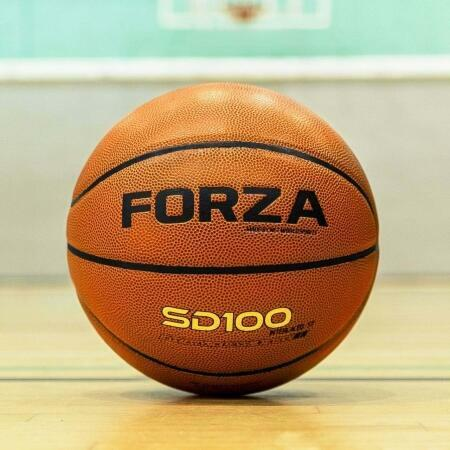

In [5]:
basketball_path = os.path.join('data','train','basketball')
basketballs = os.listdir(basketball_path)
PIL.Image.open(basketball_path + '//' + basketballs[5])

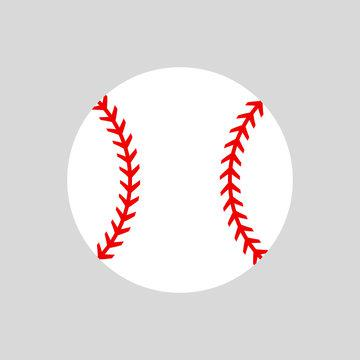

In [6]:
baseball_path = os.path.join('data','train','baseball')
baseballs = os.listdir(baseball_path)
PIL.Image.open(baseball_path + '//' + baseballs[8])

## Loading the data

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    validation_split = 0.2,
    seed = 123,
    subset="training"
)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.


In [10]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    validation_split = 0.2,
    seed = 123,
    subset="validation"
)

Found 1841 files belonging to 15 classes.
Using 368 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['american_football',
 'baseball',
 'basketball',
 'billiard_ball',
 'bowling_ball',
 'cricket_ball',
 'football',
 'golf_ball',
 'hockey_ball',
 'hockey_puck',
 'rugby_ball',
 'shuttlecock',
 'table_tennis_ball',
 'tennis_ball',
 'volleyball']

## visualizing the data

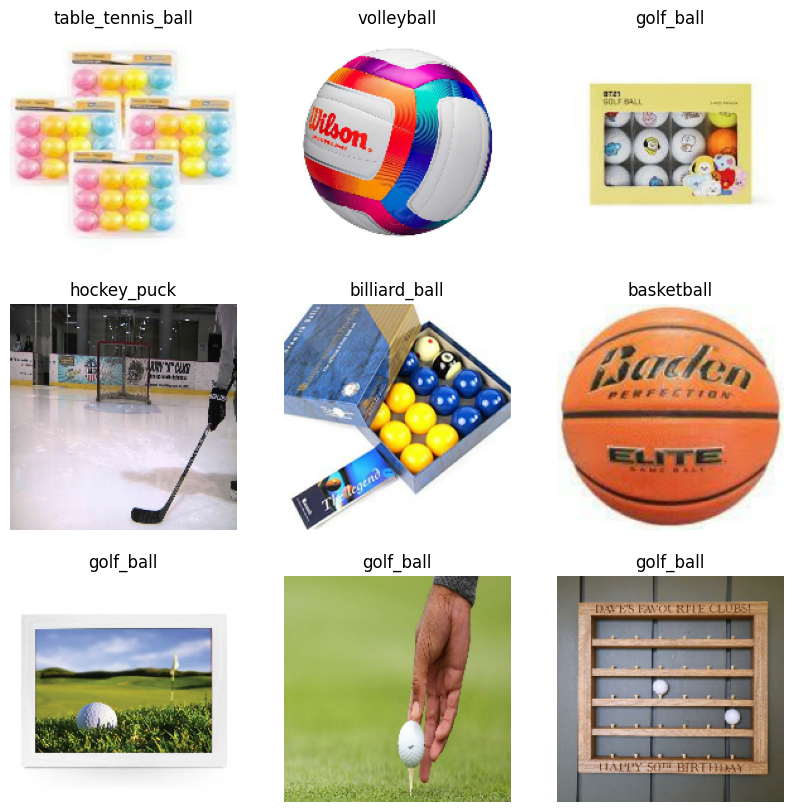

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Defining the model

In [13]:
num_classes = len(class_names)


model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compiling the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

## Training

In [16]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)

Epoch 1/15
184/184 [==============================] - 16s 34ms/step - loss: 2.5162 - accuracy: 0.1798 - val_loss: 2.4304 - val_accuracy: 0.1957
Epoch 2/15
149/184 [=======================>......] - ETA: 1s - loss: 2.1250 - accuracy: 0.3289


KeyboardInterrupt



In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 Model is overfitting : not good!

 Let's try and fix that

## Augmenting the Data + Dropout layers

In [13]:
num_classes = len(class_names)


model2 = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [14]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
epochs = 15

history = model2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs
)

Epoch 1/15
184/184 [==============================] - 64s 285ms/step - loss: 2.5231 - accuracy: 0.1784 - val_loss: 2.3152 - val_accuracy: 0.2826
Epoch 2/15
184/184 [==============================] - 54s 292ms/step - loss: 2.1996 - accuracy: 0.2946 - val_loss: 2.0440 - val_accuracy: 0.3505
Epoch 3/15
184/184 [==============================] - 54s 293ms/step - loss: 2.0135 - accuracy: 0.3582 - val_loss: 1.8639 - val_accuracy: 0.4321
Epoch 4/15
184/184 [==============================] - 54s 292ms/step - loss: 1.8583 - accuracy: 0.4158 - val_loss: 1.9193 - val_accuracy: 0.3750
Epoch 5/15
184/184 [==============================] - 53s 288ms/step - loss: 1.7130 - accuracy: 0.4629 - val_loss: 1.7966 - val_accuracy: 0.4158
Epoch 6/15
184/184 [==============================] - 52s 282ms/step - loss: 1.6033 - accuracy: 0.4919 - val_loss: 1.8329 - val_accuracy: 0.4212
Epoch 7/15
184/184 [==============================] - 50s 274ms/step - loss: 1.4869 - accuracy: 0.5349 - val_loss: 1.7910 - val_ac

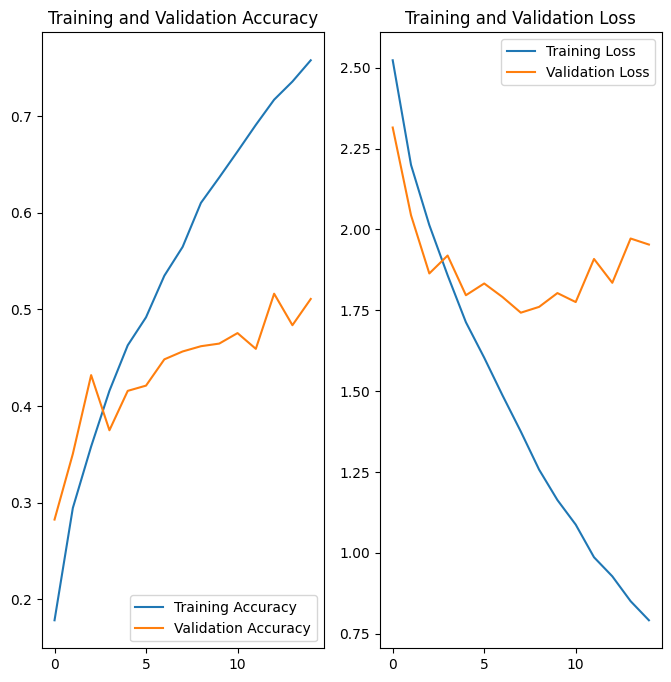

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing on unseen data

In [24]:
basketball_url = "https://as2.ftcdn.net/v2/jpg/04/68/43/83/1000_F_468438312_qklPT1lp2k4hI2KtEMb89RV8FrW0H0CM.jpg"
basketball_path = tf.keras.utils.get_file('basketball2', origin=basketball_url)

img = tf.keras.utils.load_img(
    basketball_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to basketball with a 89.74 percent confidence.
